##### **Our Project**

For our project, we decided to present 4 models our our text classification problem. The end goal for our project is to compare all four models and pick which one performed the best. 

For this project, I picked SVM to perform on the dataset. 

Scoring metric to be used is F1 score.

#### **Goals for this notebook:**

* Perform cleaning and prepping of data
* Choose a metric for scoring
* Go through SVM model for text classification

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
stop_words = stopwords.words('english')

In [8]:
# Loading the processed dataset created in the '02_Data_Exploration_Anshul_Shandilya' notebook.
df = pd.read_csv('data/cleaned_complaints.csv')

In [9]:
df.shape

(1112420, 5)

In [10]:
df.head()

,product,sub_product,issue,sub_issue,narrative
0,debt_collection,Other debt,Attempts to collect debt not owed,Debt was paid,XXXX. I do not owe any money to XXXX XXXX. I ...
1,debt_collection,Other debt,False statements or representation,Indicated you were committing crime by not pay...,XXXX is attempting to collect funds for Valuat...
2,credit_reporting_and_services,Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,EXPERIAN I didnt consent to these Inquiries Al...
3,banking_services_and_transfers,Savings account,Managing an account,Deposits and withdrawals,Citibank froze my account that contained {$200...
4,credit_reporting_and_services,Credit reporting,Improper use of your report,Reporting company used your report improperly,In accordance with the fair credit reporting a...


In [11]:
df.loc[345]['narrative']


'This is the 3rd time I try to fix this issue with Transunion. I have contact and retained XXXX XXXX XXXX, Your Credit Reporting Agency ( Transunion ) has continued to allow these accounts to report in my name materially false and fraudulent accounts. \n\nWe will also be sending out registered mail to the agency and dependent on the outcome we will choose the next legal steps. \n\nPlease cease and desist all reporting of these accounts : XXXX XXXX XXXX - {$320.00} XXXX XXXX XXXX - XXXX XXXX XXXX XXXX - XXXX Failure to fulfill your fiduciary duty as a data furnisher will inevitably result in a lawsuit filed by XXXX XXXX XXXX on my behalf. You have a fiduciary duty under the FCRA 605 ( B ) to respond within 4 business days of receipt. \n\nFCRA 605 ( b ) reads ; A consumer reporting agency shall block the reporting of any information in the file of a consumer, not later then 4 business days after the date of receipt.'

Here, we still have the narrative text in normal text. Let's see if we can do something about it.

In [12]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akaid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\akaid\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\akaid\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ["XXXX", "xxxx"]

In [14]:
import re

def process_text(text):
  '''
    Function to process the text and return a list of words with stopwords and punctuations removed
  '''
  tokens = word_tokenize(text)

  # Revove tokens with stop words removed.
  ret_tokens_st = [token.lower() for token in tokens if token.lower() not in stopwords_list]

  # Remove tokens with 2 or more consecutive x's
  for token in ret_tokens_st:
    if re.search(r'x{2,}', token):
        ret_tokens_st.remove(token)

  # Remove tokens with string that contains two or more consecutive X's
  for token in ret_tokens_st:
    if re.search(r'X{2,}', token):
        ret_tokens_st.remove(token)


  # Remove tokens with 2 or more consecutive -'s
  for token in ret_tokens_st:
    if re.search(r'-{2,}', token):
        ret_tokens_st.remove(token)

  # Remove tokens with 2 or more consecutive .'s
  for token in ret_tokens_st:
    if re.search(r'\.{2,}', token):
        ret_tokens_st.remove(token)

  # Remove tokens with float numbers
  for token in ret_tokens_st:
    if re.search(r'\d+\.\d+', token):
        ret_tokens_st.remove(token)

  # Remove tokens with date in format xx/xx/xxxx
  for token in ret_tokens_st:
    if re.search(r'\d+/\d+/\d+', token):
        ret_tokens_st.remove(token)
      
        
  # Remove tokens with numbers  
  ret_tokens = [token for token in ret_tokens_st if not token.isnumeric()]

  return ret_tokens

# function to concat words (used in function below)
def concat_words(list_of_words):
    # remove any NaN's
    # list_of_words = [i for i in list if i is not np.nan]

    concat_words = ''
    for word in list_of_words:
        concat_words += word + ' '
    return concat_words.strip()

def perform_lemmatization(text):
  '''
      Function to perform lemmatization on the text and return concatenated string of lemmatized words separated by space.
  '''
  lemmatizer = WordNetLemmatizer()
  lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
  return ' '.join(lemmatized_words)

  # # lemmatize each word
  # lemmatizer = WordNetLemmatizer()
  # lemmatized_list = []
  # for idx, word in enumerate(text):
  #     lemmatized_list.append(lemmatizer.lemmatize(word))
  
  # # make the list into a single string with the words separated by ' '
  # lemmatized_text = concat_words(lemmatized_list)


  # return lemmatized_text

In [15]:
len(df)

1112420

Since working on this dataset, the dataset is huge. So we will work only on randomly selected sample from the original dataset.

In [16]:
sample_size = 100000
sample_df = df.sample(sample_size, random_state=42)
sample_df.reset_index(inplace=True)

In [17]:
sample_df.head()
print(sample_df.shape)

(100000, 6)


In [18]:
for i in range(sample_size):
    processed = process_text(sample_df['narrative'].loc[i])
    processed_lemm = perform_lemmatization(processed)
    sample_df['narrative'].loc[i] = processed_lemm

sample_df.head()


c:\Users\akaid\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,index,product,sub_product,issue,sub_issue,narrative
0,67599,loans,Loan,Getting a loan or lease,Fraudulent loan,affiant transaction financed westlake assigned...
1,281147,loans,Loan,Problems at the end of the loan or lease,Unable to receive car title or other problem a...,paid vehicle 'm finding company never released...
2,765663,credit_reporting_and_services,Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,filing several dispute equifax still refuse re...
3,1032578,credit_reporting_and_services,Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,experian refuse proper investigation remove er...
4,95117,credit_reporting_and_services,Credit reporting,Improper use of your report,Reporting company used your report improperly,accordance fair credit reporting act account v...


##### Saving the sample dataset.

Now that we have the processed complaints with processed narrative, we will save it

In [19]:
sample_df.to_csv('data/processed_sample_df.csv', index=False)

In [20]:
sample_df = pd.read_csv('data/processed_sample_df.csv')

In [21]:
sample_df.shape

(100000, 6)

In [22]:
sample_df.isnull().sum()
sample_df.dropna(inplace=True)

Now, we have loaded the dataset. Probably 'sub_product', 'Issue' and 'sub_issue' rows are redundant for our initial work as I only plan to use the 'product' as the class labels and the 'narrative' as the training data. 

##### Initial Steps using the SVC algorithm:

* Extract the labels using preprocessing.LabelEncoder()
* Split the data using the train_test_split() function into 20% test size and the rest as training data. Shuffle will we set as True to randomise the data
* Use the 'narrative' row as our training data
* Build the initial model

Extracting the labels

In [23]:
encoded_labels = preprocessing.LabelEncoder()
labels = encoded_labels.fit_transform(sample_df['product'])

In [24]:
labels.shape

(79613,)

Splitting the data into test and train data (20% test)

In [25]:
# Splitting the dataset into train and test sets.
x_train, x_test, y_train, y_test = train_test_split(sample_df['narrative'], labels, stratify = labels, test_size=0.2, random_state=47, shuffle=True)

In [26]:
print(x_train.shape)
print(x_test.shape)

(63690,)
(15923,)


##### Now that we have our train and test data, we will build a model.

In [27]:
# Function to plot the prediced values against the actual values
def plot_actual_vs_predicted(actual, predicted):
    figure, ax = plt.subplots()
    ax.scatter(actual, predicted, edgecolors=(0, 0, 0))
    ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=4)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    plt.show()

First, I will initialise a TF-IDF model.

In [28]:
tfidf = TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1, stop_words = 'english')

Now, I will apply the TF-IDF model on both the test and train data (will take time since the num. of data is high)

In [29]:
tfidf.fit(list(x_train) + list(x_test))

TfidfVectorizer(min_df=3, ngram_range=(1, 3), smooth_idf=1,
                stop_words='english', strip_accents='unicode', sublinear_tf=1,
                token_pattern='\\w{1,}', use_idf=1)

In [30]:
x_train_tfidf =  tfidf.transform(x_train)
x_test_tfidf = tfidf.transform(x_test)

In [31]:
# Save xtrain_count and xtest_count to disk for future use.
np.save('data/x_train_tfidf.npy', x_train_tfidf)
np.save('data/x_test_tfidf.npy', x_test_tfidf)

Comment either cell above or below depending on what you need to do.

In [32]:
# x_train_tfidf = np.load('data/x_train_tfidf.npy', allow_pickle=True)
# x_test_tfidf = np.load('data/x_test_tfidf.npy', allow_pickle=True)


In [33]:
# x_train_tfidf.shape

##### **Training the SVM model**



I learned that SVM model takes a lot of time to run. Especially with close to 90000 components, it probably won't end before at least a couple of hours. So need to reduce the number of components before I proceed.

Reducing the number of components. (Using Singular Value Decomposition)

Initially, will try reducing to 300 components. 

In [34]:
# Initializing and applying SVD on the TF-IDF vectorized data to reduce the num. of components to 250.
svd = TruncatedSVD(n_components=250)
svd.fit(x_train_tfidf)
x_train_svd = svd.transform(x_train_tfidf)
x_test_svd = svd.transform(x_test_tfidf)


Now that we have the components reduced (using SVD), since SMV is a linear model, we need to normalize the data before we try to fit the data into SVM.

In [35]:
# Normalizing the data using StandardScaler.
scl = preprocessing.StandardScaler()
scl.fit(x_train_svd)
x_train_svd_scl = scl.transform(x_train_svd)
x_test_svd_scl = scl.transform(x_test_svd)

In [36]:
# Creating and traininng a SVC model
svm_model = SVC(C=1.0, probability=True)
svm_model.fit(x_train_svd_scl, y_train)
preds = svm_model.predict(x_test_svd_scl)


In [37]:
# Printing the F-1 score
print("F1 score: ", metrics.f1_score(y_test, preds, average='weighted'))


F1 score:  0.869822882025111


In [38]:
y_train.shape
y_test.shape

(15923,)

In [39]:
preds.shape

(15923,)

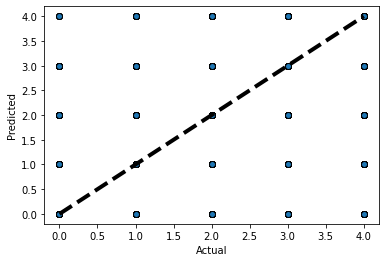

In [40]:
# Plot the predicted values against the actual values.
plot_actual_vs_predicted(y_test, preds)

Also, I will try **logistic regression** below


One of the alternatives for TF-IDF is count vectorizer feature extraction. 

In [41]:
# Initializing and training a count vector model
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1, 3), stop_words = 'english')
count_vect.fit(list(x_train) + list(x_test))
xtrain_count =  count_vect.transform(x_train)
xtest_count = count_vect.transform(x_test)

In [42]:
# Save xtrain_count and xtest_count to disk for future use.
np.save('data/xtrain_count.npy', xtrain_count)
np.save('data/xtest_count.npy', xtest_count)

In [43]:
# Initializing and training a logistic regression model
logistic_model = LogisticRegression(C=1.0)
logistic_model.fit(xtrain_count, y_train)
preds = logistic_model.predict(xtest_count)

c:\Users\akaid\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [44]:
# Printing the F1 score
print("F1 score: ", metrics.f1_score(y_test, preds, average='weighted'))

F1 score:  0.8680749166011059


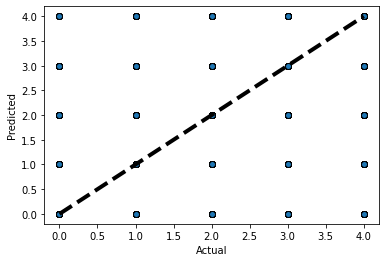

In [48]:
# Plot the acvtual values against the predicted values.
plot_actual_vs_predicted(y_test, preds)

#### **Observations:**

* For sample_size=10000, two  models were trained:

    * **SVM** - F1 score = 0.8347134811772894
    
    * **Logistic Regression** - F1 score = 0.8049101124053899

    **For 10,000 samples taken from the dataset, SVM performed relatively better than Logistic Regression.** 

<br>

Since I took 10,000 samples, which is a fraction of close to million columns of data, I re-tried the same process with 100,000 samples.

* For sample_size=100,000, two  models were trained:

    * **SVM** - F1 score = 0.8550971142924789
    
    * **Logistic Regression** - F1 score = 0.854402883400011

    **But for 100,000 samples taken from the dataset, SVM still performed better than Logistic Regression but the differnece between them was relatively smaller.**
    